In [22]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
ARTIFACT_DIR = os.path.join(BASE_DIR, "artifacts_v2")
DATA_DIR = os.path.join(BASE_DIR, "data")
TEST_IMG_DIR = os.path.join(BASE_DIR, "images", "test")

X_train = np.load(os.path.join(ARTIFACT_DIR, "X_train_tab_v2.npy"))
X_val = np.load(os.path.join(ARTIFACT_DIR, "X_val_tab_v2.npy"))
X_test = np.load(os.path.join(ARTIFACT_DIR, "X_test_tab_v2.npy"))

y_train = np.load(os.path.join(ARTIFACT_DIR, "y_train_v2.npy"))
y_val = np.load(os.path.join(ARTIFACT_DIR, "y_val_v2.npy"))

test_df = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))


In [3]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [9]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return rmse, r2


In [10]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rf_preds = rf.predict(X_val)

mse_rf = mean_squared_error(y_val, rf_preds)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_val, rf_preds)

print(f"RF RMSE: {rmse_rf:.2f}")
print(f"RF R²: {r2_rf:.4f}")


RF RMSE: 126369.70
RF R²: 0.8727


In [7]:
xgb = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [13]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse_xgb = np.sqrt(mean_squared_error(y_val, val_preds))
r2_xgb = r2_score(y_val, val_preds)

print(f"XGB RMSE: {rmse_xgb:.2f}")
print(f"XGB R²: {r2_xgb:.3f}")


XGB RMSE: 117588.97
XGB R²: 0.890


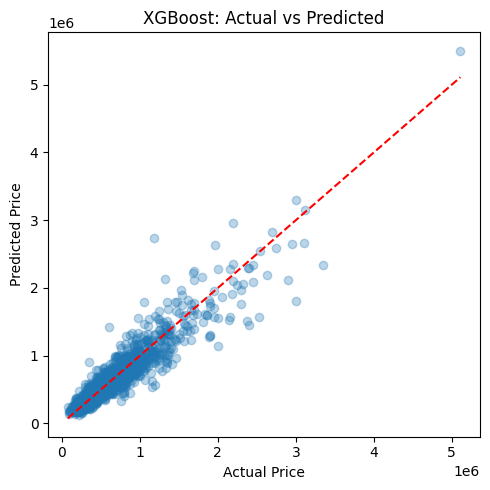

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(y_val, val_preds, alpha=0.3)
plt.plot(
    [y_val.min(), y_val.max()],
    [y_val.min(), y_val.max()],
    "r--"
)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("XGBoost: Actual vs Predicted")
plt.tight_layout()
plt.show()


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

cnn = models.resnet18(pretrained=True)
cnn.fc = nn.Identity()
cnn.to(device)
cnn.eval()


c:\Users\hp\OneDrive\Desktop\project_cdc\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hp\OneDrive\Desktop\project_cdc\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

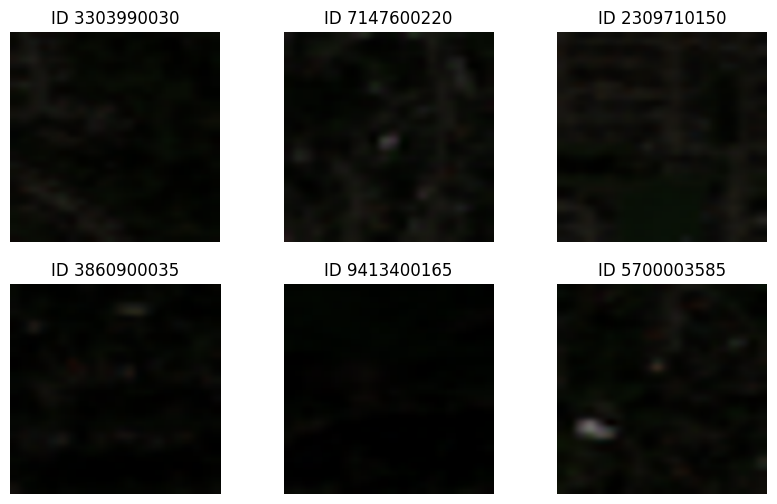

In [16]:
sample_ids = test_df["id"].sample(6, random_state=42)

plt.figure(figsize=(10,6))
for i, pid in enumerate(sample_ids, 1):
    img = Image.open(os.path.join(TEST_IMG_DIR, f"{pid}.png"))
    plt.subplot(2,3,i)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"ID {pid}")
plt.show()


In [17]:
embeddings = []

with torch.no_grad():
    for pid in tqdm(test_df["id"]):
        path = os.path.join(TEST_IMG_DIR, f"{pid}.png")

        if not os.path.exists(path):
            embeddings.append(np.zeros(512))
            continue

        img = Image.open(path).convert("RGB")
        img = transform(img).unsqueeze(0).to(device)
        emb = cnn(img).cpu().numpy().squeeze()
        embeddings.append(emb)

X_img_test = np.array(embeddings)

np.save(os.path.join(ARTIFACT_DIR, "X_img_test_v2.npy"), X_img_test)


100%|██████████| 5404/5404 [03:41<00:00, 24.41it/s]


In [18]:
X_fusion_test = np.hstack([X_test, X_img_test])
print("Fusion shape:", X_fusion_test.shape)


Fusion shape: (5404, 525)


In [19]:
test_predictions = xgb.predict(X_test)


In [20]:
prediction_df = pd.DataFrame({
    "id": test_df["id"],
    "predicted_price": test_predictions
})

prediction_path = os.path.join(BASE_DIR, "prediction.csv")
prediction_df.to_csv(prediction_path, index=False)

print("✅ prediction.csv saved")


✅ prediction.csv saved


In [25]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        self.model.zero_grad()
        output = self.model(input_tensor)

        # Regression → single output
        output.backward(torch.ones_like(output))

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)

        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam


In [27]:
target_layer = cnn.layer4[-1]
cam = GradCAM(cnn, target_layer)



In [32]:
import os

print(os.listdir("../images/test")[:10])


['1000102.png', '100100050.png', '1001200035.png', '100300500.png', '1005000036.png', '1005000220.png', '1005000240.png', '100600320.png', '100600860.png', '1020069017.png']


In [33]:
from PIL import Image
import os

img_dir = "../images/test"
img_name = os.listdir(img_dir)[0]
img_path = os.path.join(img_dir, img_name)

img_pil = Image.open(img_path).convert("RGB")
print("Using image:", img_name)


Using image: 1000102.png


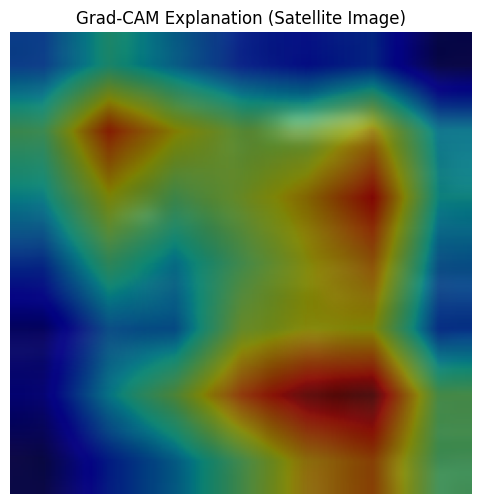

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F

# Generate CAM
cam_map = cam.generate(transform(img_pil).unsqueeze(0).to(device))
cam_map = cam_map[0].unsqueeze(0).unsqueeze(0)  # shape: 1x1x7x7

# Upsample CAM to image size (smooth)
cam_map = F.interpolate(
    cam_map,
    size=(224, 224),
    mode="bilinear",
    align_corners=False
)

cam_map = cam_map.squeeze().cpu().numpy()

# Prepare image
img_np = np.array(img_pil.resize((224,224))).astype(np.float32) / 255.0

# Overlay
plt.figure(figsize=(6,6))
plt.imshow(img_np)
plt.imshow(cam_map, cmap="jet", alpha=0.5)
plt.axis("off")
plt.title("Grad-CAM Explanation (Satellite Image)")
plt.show()
